In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb


In [4]:
# Load the data
df = pd.read_csv('dummy_data.csv')
df.head()

,age,gender,time_spent,platform,interests,location,demographics,profession,income,indebt,isHomeOwner,Owns_Car
0,56,male,3,Instagram,Sports,United Kingdom,Urban,Software Engineer,19774,True,False,False
1,46,female,2,Facebook,Travel,United Kingdom,Urban,Student,10564,True,True,True
2,32,male,8,Instagram,Sports,Australia,Sub_Urban,Marketer Manager,13258,False,False,False
3,60,non-binary,5,Instagram,Travel,United Kingdom,Urban,Student,12500,False,True,False
4,25,male,1,Instagram,Lifestlye,Australia,Urban,Software Engineer,14566,False,True,True


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   age           1000 non-null   int64 
 1   gender        1000 non-null   object
 2   time_spent    1000 non-null   int64 
 3   platform      1000 non-null   object
 4   interests     1000 non-null   object
 5   location      1000 non-null   object
 6   demographics  1000 non-null   object
 7   profession    1000 non-null   object
 8   income        1000 non-null   int64 
 9   indebt        1000 non-null   bool  
 10  isHomeOwner   1000 non-null   bool  
 11  Owns_Car      1000 non-null   bool  
dtypes: bool(3), int64(3), object(6)
memory usage: 73.4+ KB


In [5]:
df.describe()

,age,time_spent,income
count,1000.000000,1000.000000,1000.000000
mean,40.986000,5.029000,15014.823000
std,13.497852,2.537834,2958.628221
min,18.000000,1.000000,10012.000000
25%,29.000000,3.000000,12402.250000
50%,42.000000,5.000000,14904.500000
75%,52.000000,7.000000,17674.250000
max,64.000000,9.000000,19980.000000


In [13]:
df['interests'].value_counts()

interests
Lifestlye    341
Sports       331
Travel       328
Name: count, dtype: int64

In [22]:
# convert gender, interests, location, demographics, platform and profession to one hot encoding
df_enc = pd.get_dummies(df, columns=['gender', 'interests', 'location', 'demographics', 'profession', 'platform'], drop_first=False)
df_enc

,age,time_spent,income,indebt,isHomeOwner,Owns_Car,gender_female,gender_male,gender_non-binary,interests_Lifestlye,...,location_United States,demographics_Rural,demographics_Sub_Urban,demographics_Urban,profession_Marketer Manager,profession_Software Engineer,profession_Student,platform_Facebook,platform_Instagram,platform_YouTube
0,56,3,19774,True,False,False,False,True,False,False,...,False,False,False,True,False,True,False,False,True,False
1,46,2,10564,True,True,True,True,False,False,False,...,False,False,False,True,False,False,True,True,False,False
2,32,8,13258,False,False,False,False,True,False,False,...,False,False,True,False,True,False,False,False,True,False
3,60,5,12500,False,True,False,False,False,True,False,...,False,False,False,True,False,False,True,False,True,False
4,25,1,14566,False,True,True,False,True,False,True,...,False,False,False,True,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,22,8,18536,False,True,False,True,False,False,True,...,False,True,False,False,True,False,False,False,True,False
996,40,6,12711,True,False,False,False,False,True,False,...,False,True,False,False,False,True,False,False,False,True
997,27,5,17595,True,False,True,False,False,True,False,...,False,True,False,False,False,False,True,False,False,True
998,61,4,16273,True,True,False,True,False,False,False,...,False,False,True,False,True,False,False,False,False,True


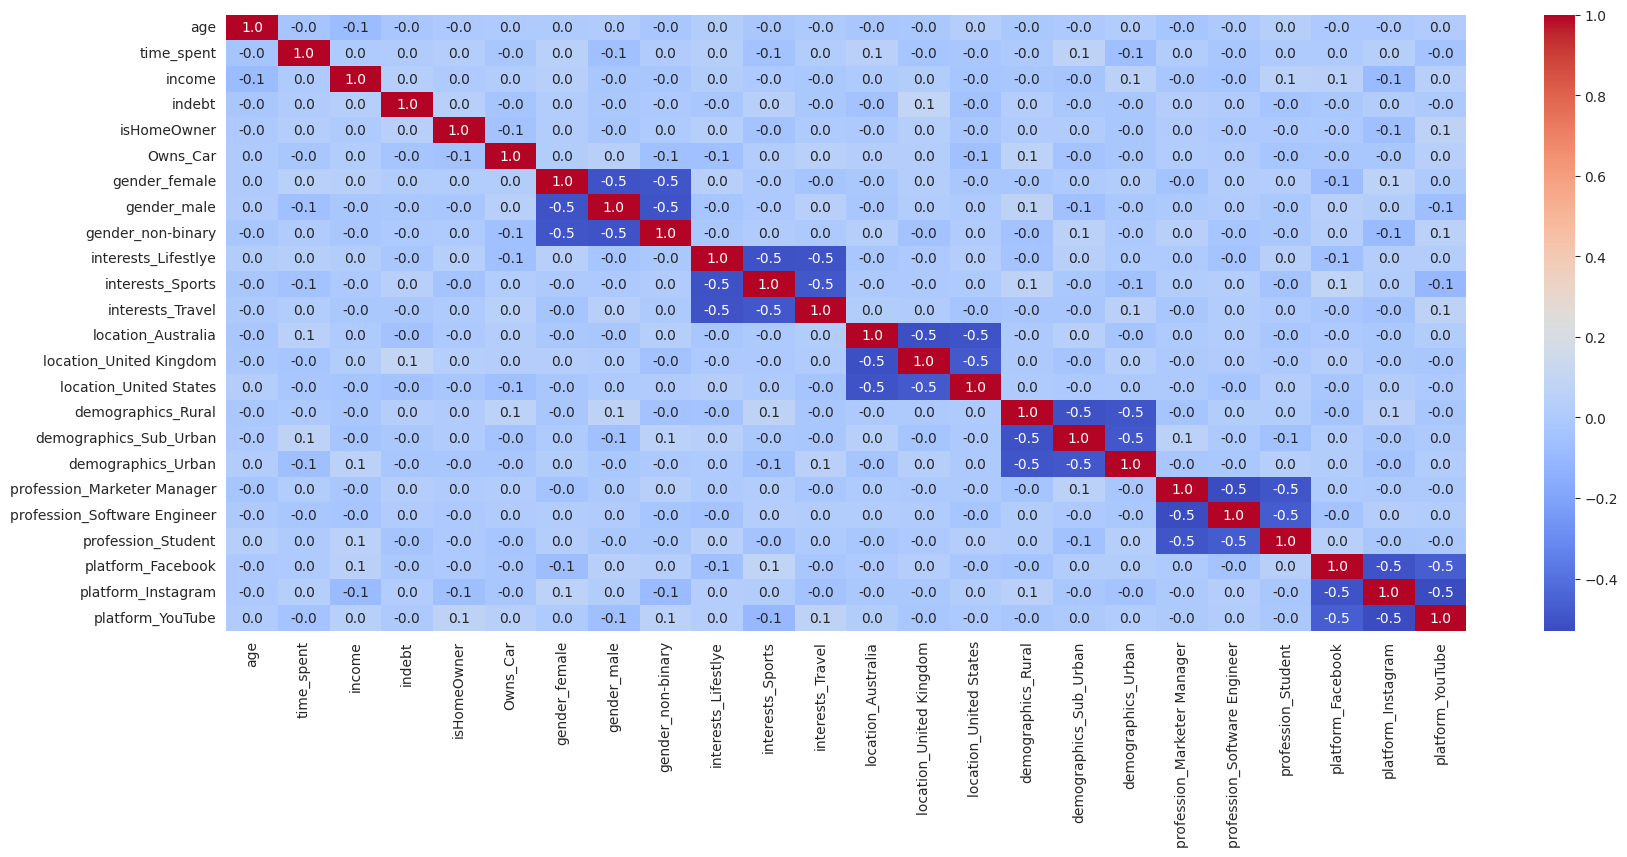

In [23]:
# correlation matrix
corr = df_enc.corr()
plt.figure(figsize = (20,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.1f')
plt.show()


In [27]:
# normalize income and age
df_enc['income'] = (df_enc['income'] - df_enc['income'].min()) / (df_enc['income'].max() - df_enc['income'].min())
df_enc['age'] = (df_enc['age'] - df_enc['age'].min()) / (df_enc['age'].max() - df_enc['age'].min())    

In [28]:
df_enc

,age,time_spent,income,indebt,isHomeOwner,Owns_Car,gender_female,gender_male,gender_non-binary,interests_Lifestlye,...,location_United States,demographics_Rural,demographics_Sub_Urban,demographics_Urban,profession_Marketer Manager,profession_Software Engineer,profession_Student,platform_Facebook,platform_Instagram,platform_YouTube
0,0.826087,3,0.979334,True,False,False,False,True,False,False,...,False,False,False,True,False,True,False,False,True,False
1,0.608696,2,0.055377,True,True,True,True,False,False,False,...,False,False,False,True,False,False,True,True,False,False
2,0.304348,8,0.325642,False,False,False,False,True,False,False,...,False,False,True,False,True,False,False,False,True,False
3,0.913043,5,0.249599,False,True,False,False,False,True,False,...,False,False,False,True,False,False,True,False,True,False
4,0.152174,1,0.456862,False,True,True,False,True,False,True,...,False,False,False,True,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.086957,8,0.855136,False,True,False,True,False,False,True,...,False,True,False,False,True,False,False,False,True,False
996,0.478261,6,0.270766,True,False,False,False,False,True,False,...,False,True,False,False,False,True,False,False,False,True
997,0.195652,5,0.760734,True,False,True,False,False,True,False,...,False,True,False,False,False,False,True,False,False,True
998,0.934783,4,0.628110,True,True,False,True,False,False,False,...,False,False,True,False,True,False,False,False,False,True


In [29]:
# split the data into train, val and test
X = df_enc.drop('time_spent', axis=1)
y = df_enc['time_spent']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [107]:
X_train.shape, X_val.shape, X_test.shape

((640, 23), (160, 23), (200, 23))

In [98]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        'eta': [0.01, 0.1, 0.2],
        }

In [103]:
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, nthread=1)

In [104]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle = True, random_state=1001)

In [109]:
from sklearn.model_selection import RandomizedSearchCV

combined_X = pd.concat([X_train, X_val])
combined_y = pd.concat([y_train, y_val])
random_search = RandomizedSearchCV(model, param_distributions=params, n_iter=10000, scoring='neg_root_mean_squared_error', n_jobs=4, 
                                   cv=skf.split(combined_X, combined_y), verbose=3, random_state=1001)

random_search.fit(combined_X, combined_y)

/home/christian/Desktop/social-media-time-pred/venv/lib/python3.10/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 1215 is smaller than n_iter=10000. Running 1215 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 1215 candidates, totalling 6075 fits
[CV 2/5] END colsample_bytree=1.0, gamma=5, max_depth=3, min_child_weight=5, subsample=1.0;, score=nan total time=   0.0s
[CV 5/5] END colsample_bytree=1.0, gamma=5, max_depth=3, min_child_weight=5, subsample=1.0;, score=nan total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=1, subsample=0.6;, score=nan total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weight=1, subsample=0.6;, score=nan total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=1, max_depth=5, min_child_weight=5, subsample=0.8;, score=nan total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=1, max_depth=5, min_child_weight=5, subsample=0.8;, score=nan total time=   0.0s
[CV 3/5] END colsample_bytree=0.6, gamma=5, max_depth=5, min_child_weight=5, subsample=1.0;, score=nan total time=   0.0s
[CV 5/5] END colsample_bytree=0.6, gamma=5, max_depth=5, min_child_weight=5, 

RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7a08c06513f0>,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=...
                                          multi_strategy=None,
                                          n_estimators=1000, n_jobs=None,
                                          nthread=1, num_parallel_tree=None, ...),
                   n_iter=10000, n_jobs=4,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'eta': [0.01, 0.1, 0.2],
                                        'gamma': [0.5, 1, 1.5, 2, 5],
                                        'max_depth': [3, 4, 5],
                                        'min_child_weight': [1, 5, 10],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=1001, scoring='neg_root_mean_squared_error',
                   verbose=3)

In [113]:
random_search.best_score_

-2.5449839969141523

In [114]:
random_search.best_params_

{'subsample': 1.0,
 'min_child_weight': 1,
 'max_depth': 4,
 'gamma': 5,
 'eta': 0.01,
 'colsample_bytree': 0.6}

In [115]:
best_model = random_search.best_estimator_

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

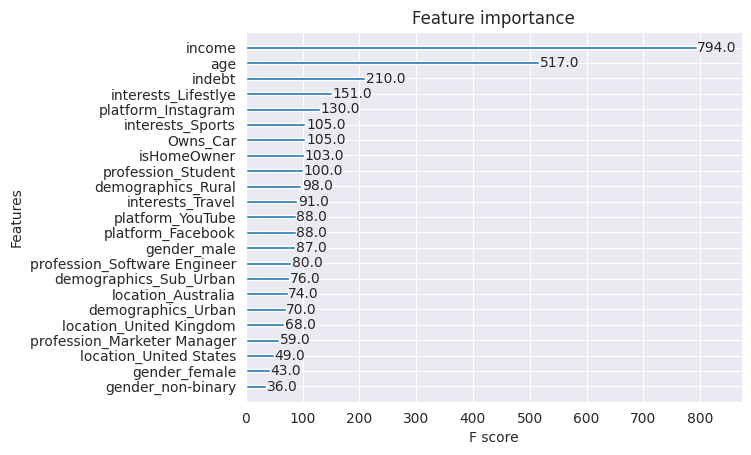

In [116]:
#plot feature importance
xgb.plot_importance(best_model)